<a href="https://colab.research.google.com/github/AlinaZemlyakova/CompLing-2021-2022/blob/main/hw8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание № 8

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# функция для f1-меры для tensorflow

from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Задание 1 (4 балла) 

Обучите 8 моделей для задачи классификации текста (датасет - lenta_40k ). А именно:  
1) модель с 1 GRU слоем;   
2) модель с 1 LSTM слоем    
3) модель с 1 GRU и 1 LSTM слоем  
4) модель с 1 BIGRU и 2 LSTM слоями  
5) модель с 5 GRU слоями и 3 LSTM слоями  
6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались   
7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM


Параметр units и размер эмбединга можете задать любой. Оцените качество каждой модели и определите победителя.

Ссылка на лекционные материалы: https://colab.research.google.com/drive/10bzAmh4hnJvGo2QmsKzulcWWkTehj71W#scrollTo=bupKIqMRXkp0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/My Drive/lenta_40k.csv.zip')

In [ ]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [ ]:
# создаем словарь из уникальных токенов и их частотности
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [ ]:
# убираем редко встречающиеся токены (менее 30 раз) и сохраняем только частотность
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [ ]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

# переводим тексты в последовательности индексов
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [ ]:
# оптимальная длина текста
MEAN_LEN = np.median([len(x) for x in X])
MAX_LEN = int(MEAN_LEN + 30)

In [ ]:
# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [ ]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [ ]:
y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [ ]:
# стратификация для баланса классов
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

1) модель с 1 GRU слоем

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

rnn = tf.keras.layers.GRU(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=15)

Epoch 1/15
43/43 [==============================] - 129s 3s/step - loss: 2.5671 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3270 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/15
43/43 [==============================] - 102s 2s/step - loss: 2.2888 - f1: 0.0000e+00 - rec@prec: 9.4926e-05 - val_loss: 2.2570 - val_f1: 0.0000e+00 - val_rec@prec: 4.5086e-04
Epoch 3/15
43/43 [==============================] - 103s 2s/step - loss: 2.1409 - f1: 0.0050 - rec@prec: 4.7463e-05 - val_loss: 2.1053 - val_f1: 0.0237 - val_rec@prec: 0.0090
Epoch 4/15
43/43 [==============================] - 101s 2s/step - loss: 1.9625 - f1: 0.0846 - rec@prec: 0.0012 - val_loss: 2.0430 - val_f1: 0.0718 - val_rec@prec: 0.0086
Epoch 5/15
43/43 [==============================] - 100s 2s/step - loss: 1.7100 - f1: 0.2458 - rec@prec: 0.0734 - val_loss: 1.7780 - val_f1: 0.2001 - val_rec@prec: 0.0338
Epoch 6/15
43/43 [==============================] - 103s 2s/step - loss: 1.4829 - f1: 0.3646 - rec@prec: 0.21

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


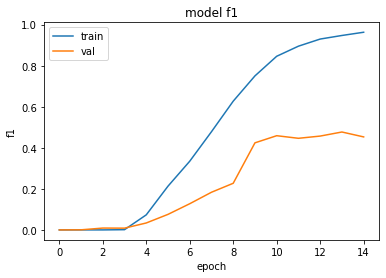

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

2) модель с 1 LSTM слоем

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

rnn = tf.keras.layers.LSTM(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=15)

Epoch 1/15
43/43 [==============================] - 137s 3s/step - loss: 2.4775 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3226 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/15
43/43 [==============================] - 122s 3s/step - loss: 2.3111 - f1: 0.0000e+00 - rec@prec: 4.7463e-05 - val_loss: 2.2927 - val_f1: 0.0000e+00 - val_rec@prec: 0.0036
Epoch 3/15
43/43 [==============================] - 121s 3s/step - loss: 2.2154 - f1: 0.0033 - rec@prec: 3.0851e-04 - val_loss: 2.0748 - val_f1: 0.0136 - val_rec@prec: 0.0054
Epoch 4/15
43/43 [==============================] - 122s 3s/step - loss: 1.8855 - f1: 0.0645 - rec@prec: 0.0231 - val_loss: 1.8484 - val_f1: 0.1915 - val_rec@prec: 0.1069
Epoch 5/15
43/43 [==============================] - 122s 3s/step - loss: 1.7437 - f1: 0.2140 - rec@prec: 0.1308 - val_loss: 1.7124 - val_f1: 0.2023 - val_rec@prec: 0.1285
Epoch 6/15
43/43 [==============================] - 122s 3s/step - loss: 1.4964 - f1: 0.3997 - rec@prec: 0.2199 -

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


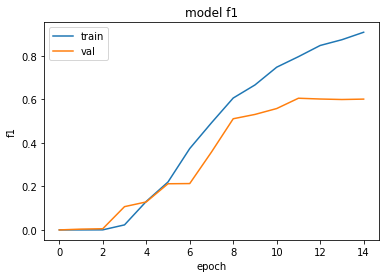

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

3) модель с 1 GRU и 1 LSTM слоем

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm_1 = tf.keras.layers.GRU(128, return_sequences=True)(embeddings)
lstm_2 = tf.keras.layers.LSTM(128, return_sequences=False)(lstm_1)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm_2)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=15)

Epoch 1/15
43/43 [==============================] - 290s 7s/step - loss: 2.4984 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3140 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/15
43/43 [==============================] - 273s 6s/step - loss: 2.1431 - f1: 0.0019 - rec@prec: 0.0019 - val_loss: 1.9086 - val_f1: 0.0325 - val_rec@prec: 0.0216
Epoch 3/15
43/43 [==============================] - 277s 6s/step - loss: 1.7650 - f1: 0.1125 - rec@prec: 0.0648 - val_loss: 1.7881 - val_f1: 0.0968 - val_rec@prec: 0.0694
Epoch 4/15
43/43 [==============================] - 279s 6s/step - loss: 1.6183 - f1: 0.1516 - rec@prec: 0.0872 - val_loss: 1.6854 - val_f1: 0.1588 - val_rec@prec: 0.0875
Epoch 5/15
43/43 [==============================] - 274s 6s/step - loss: 1.5246 - f1: 0.2175 - rec@prec: 0.1082 - val_loss: 1.6783 - val_f1: 0.2818 - val_rec@prec: 0.1046
Epoch 6/15
43/43 [==============================] - 274s 6s/step - loss: 1.4499 - f1: 0.3405 - rec@prec: 0.1386 - val_loss: 1.679

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


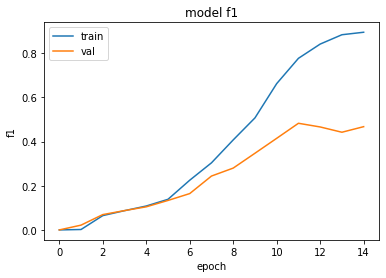

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

4) модель с 1 BIGRU и 2 LSTM слоями

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )

bigru = tf.keras.layers.LSTM(128, return_sequences=True)(embeddings)
lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(bigru)
lstm_2 = tf.keras.layers.LSTM(128, return_sequences=False)(lstm_1)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=15)

Epoch 1/15
43/43 [==============================] - 698s 16s/step - loss: 2.4067 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.2739 - val_f1: 0.0000e+00 - val_rec@prec: 0.0050
Epoch 2/15
43/43 [==============================] - 660s 15s/step - loss: 1.9566 - f1: 0.0469 - rec@prec: 0.0047 - val_loss: 1.7284 - val_f1: 0.1844 - val_rec@prec: 0.0469
Epoch 3/15
43/43 [==============================] - 665s 15s/step - loss: 1.4403 - f1: 0.4255 - rec@prec: 0.2257 - val_loss: 1.3913 - val_f1: 0.5072 - val_rec@prec: 0.3345
Epoch 4/15
43/43 [==============================] - 662s 15s/step - loss: 1.1624 - f1: 0.6202 - rec@prec: 0.4875 - val_loss: 1.4050 - val_f1: 0.5645 - val_rec@prec: 0.3363
Epoch 5/15
43/43 [==============================] - 690s 16s/step - loss: 1.0082 - f1: 0.6753 - rec@prec: 0.5865 - val_loss: 1.3476 - val_f1: 0.5796 - val_rec@prec: 0.3882
Epoch 6/15
43/43 [==============================] - 723s 17s/step - loss: 0.8765 - f1: 0.7306 - rec@prec: 0.6888 - val_loss: 1.2

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


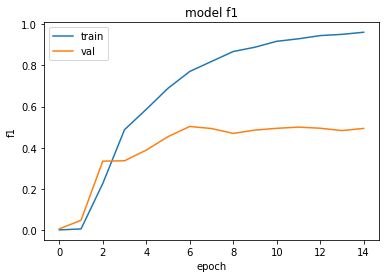

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

5) модель с 5 GRU слоями и 3 LSTM слоями

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

gru_1 = tf.keras.layers.GRU(128, return_sequences=True)(embeddings)
gru_2 = tf.keras.layers.GRU(128, return_sequences=True)(gru_1)
gru_3 = tf.keras.layers.GRU(128, return_sequences=True)(gru_2)
gru_4 = tf.keras.layers.GRU(128, return_sequences=True)(gru_3)
gru_5 = tf.keras.layers.GRU(128, return_sequences=True)(gru_4)
lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True)(gru_5)
lstm_2 = tf.keras.layers.LSTM(128, return_sequences=True)(lstm_1)
lstm_3 = tf.keras.layers.LSTM(128, return_sequences=False)(lstm_2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_3)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10)

Epoch 1/10
43/43 [==============================] - 1358s 31s/step - loss: 2.6966 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3813 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/10
43/43 [==============================] - 1318s 31s/step - loss: 2.3486 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3301 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/10
43/43 [==============================] - 1317s 31s/step - loss: 2.3278 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3238 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 4/10
43/43 [==============================] - 1299s 30s/step - loss: 2.3238 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3191 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 5/10
43/43 [==============================] - 1304s 30s/step - loss: 2.2780 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.1833 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 6/10
43/43 [==============================] - 131

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


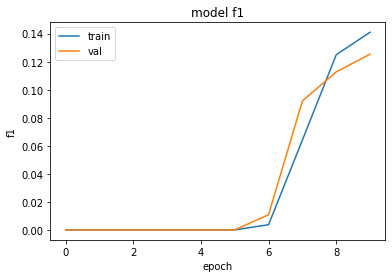

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

bilstm_forward = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=False))(embeddings)
bigru_backward = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=False, go_backwards=True))(embeddings)

hidden = tf.keras.layers.concatenate([bilstm_forward, bigru_backward])

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(hidden)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=15)

Epoch 1/15
43/43 [==============================] - 442s 10s/step - loss: 2.4601 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3061 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/15
43/43 [==============================] - 423s 10s/step - loss: 2.2178 - f1: 0.0011 - rec@prec: 3.0851e-04 - val_loss: 1.9995 - val_f1: 0.0166 - val_rec@prec: 0.0365
Epoch 3/15
43/43 [==============================] - 423s 10s/step - loss: 1.6787 - f1: 0.1890 - rec@prec: 0.0744 - val_loss: 1.5568 - val_f1: 0.2242 - val_rec@prec: 0.1506
Epoch 4/15
43/43 [==============================] - 418s 10s/step - loss: 1.4040 - f1: 0.3275 - rec@prec: 0.1941 - val_loss: 1.4289 - val_f1: 0.3720 - val_rec@prec: 0.1898
Epoch 5/15
43/43 [==============================] - 423s 10s/step - loss: 1.2209 - f1: 0.4890 - rec@prec: 0.3401 - val_loss: 1.2719 - val_f1: 0.5392 - val_rec@prec: 0.3061
Epoch 6/15
43/43 [==============================] - 424s 10s/step - loss: 1.0297 - f1: 0.6333 - rec@prec: 0.5282 - val_l

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


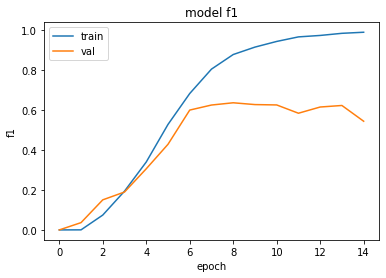

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True)(embeddings)
gru_1 = tf.keras.layers.GRU(128, return_sequences=True)(lstm_1)
bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(gru_1)
bigru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(bilstm)
gru_2 = tf.keras.layers.GRU(128, return_sequences=True)(bigru)
lstm_2 = tf.keras.layers.LSTM(128, return_sequences=False)(gru_2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10)

Epoch 1/10
43/43 [==============================] - 1493s 34s/step - loss: 2.7056 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3725 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/10
43/43 [==============================] - 1444s 34s/step - loss: 2.3447 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3269 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/10
43/43 [==============================] - 1477s 34s/step - loss: 2.3210 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3055 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 4/10
43/43 [==============================] - 1493s 35s/step - loss: 2.1896 - f1: 0.0000e+00 - rec@prec: 5.2209e-04 - val_loss: 2.0976 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 5/10
43/43 [==============================] - 1476s 34s/step - loss: 1.9629 - f1: 0.0442 - rec@prec: 0.0000e+00 - val_loss: 1.9131 - val_f1: 0.0890 - val_rec@prec: 0.0054
Epoch 6/10
43/43 [==============================] - 1487s 34s/step 

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


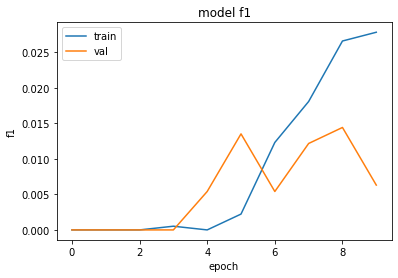

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Итоговые результаты:**

1) модель с 1 GRU слоем: f1: 0.9275 val_f1: 0.6354

2) модель с 1 LSTM слоем: f1: 0.8694 val_f1: 0.7104

3) модель с 1 GRU и 1 LSTM слоем: f1: 0.8605 val_f1: 0.6455

4) модель с 1 BIGRU и 2 LSTM слоями: f1: 0.9272 val_f1: 0.6334

5) модель с 5 GRU слоями и 3 LSTM слоями: f1: 0.3427 val_f1: 0.3306

6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались: f1: 0.9638 val_f1: 0.6940

7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM: f1: 0.2845 val_f1: 0.2514

Самый лучший результат на валидации у модели с 1 LSTM слоем, на тестовой выборке -- у модели с 1 BIGRU и 1 BILSTM слоями с разными forward и backward проходами. Увеличение слоев приводит к ухудшению результата.

## Задание 2 (6 баллов)


На данных википедии (wikiann) обучите 2 модели:  
1) модель в которой будут использованы предобученные эмбединги слов и несколько BILSTM слоев. 
1) модель в которой будут использованы предобученные эмбединги слов и несколько BIGRU слоев. 

Сравните качество по метрикам. Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

In [ ]:
!pip install datasets
!pip install slovnet
!pip install navec

from datasets import load_dataset
from navec import Navec
from slovnet.model.emb import NavecEmbedding

dataset = load_dataset('wikiann', 'ru')

     |████████████████████████████████| 342 kB 4.9 MB/s 
     |████████████████████████████████| 212 kB 53.0 MB/s 
     |████████████████████████████████| 140 kB 43.6 MB/s 
     |████████████████████████████████| 1.1 MB 45.1 MB/s 
     |████████████████████████████████| 84 kB 2.8 MB/s 
     |████████████████████████████████| 127 kB 35.5 MB/s 
     |████████████████████████████████| 94 kB 2.9 MB/s 
     |████████████████████████████████| 271 kB 42.0 MB/s 
     |████████████████████████████████| 144 kB 46.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


     |████████████████████████████████| 49 kB 2.7 MB/s 


Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Dataset wikiann downloaded and prepared to /root/.cache/huggingface/datasets/wikiann/ru/1.1.0/4bfd4fe4468ab78bb6e096968f61fab7a888f44f9d3371c2f3fea7e74a5a354e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# словарь
vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])

In [ ]:
# индексируем слова
word2id = {'<pad>':0, '<unk>':1}

for word in vocab:
    word2id[word] = len(word2id)

In [ ]:
id2word = {i:word for word, i in word2id.items()}

In [ ]:
# переводим тексты в последовательности индексов
X = []

for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [ ]:
# переводим тексты в последовательности индексов
X_test = []

for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

In [ ]:
MAX_LEN = max(len(x) for x in X)

# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

In [ ]:
id2labels = {0:'O', 1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG', 5: 'B-LOC', 6:'I-LOC', 7:'PAD'}
label2id = {v:k for k,v in id2labels.items()} 

In [ ]:
y = tf.keras.preprocessing.sequence.pad_sequences(dataset['train']['ner_tags'], value=7,
                                                  maxlen=MAX_LEN,  padding='post')
y_test = tf.keras.preprocessing.sequence.pad_sequences(dataset['test']['ner_tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

В качестве предобученных эмбеддингов используем эмбеддинги из библиотеки navec.

In [ ]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

--2022-05-20 10:01:48--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  16.2MB/s    in 3.1s    

2022-05-20 10:01:52 (16.2 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



In [ ]:
path = '/content/navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)
emb = NavecEmbedding(navec)

/usr/local/lib/python3.7/dist-packages/slovnet/model/emb.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  torch.from_numpy(navec.pq.indexes),


In [ ]:
embedding_matrix = np.zeros((len(word2id), 300))
for id in id2word:
  try:
    navec_id = navec.vocab[id2word[id]]
    input = np.asarray(navec_id)    
    embedding_vector = emb(input)
  except KeyError:
    embedding_vector = navec.vocab['<unk>']
  embedding_matrix[id] = embedding_vector

In [ ]:
embeddings = tf.keras.layers.Embedding(
    len(word2id),
    300,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
    )

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = embeddings(inputs)

bilstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embeddings)
bilstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(bilstm_1)
bilstm_3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(bilstm_2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(bilstm_3)

model_bilstm = tf.keras.Model(inputs=inputs, outputs=outputs)
model_bilstm.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

In [ ]:
model_bilstm.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=5)

Epoch 1/5
157/157 [==============================] - 303s 2s/step - loss: 0.1825 - accuracy: 0.9515 - val_loss: 0.0955 - val_accuracy: 0.9686
Epoch 2/5
157/157 [==============================] - 274s 2s/step - loss: 0.0673 - accuracy: 0.9791 - val_loss: 0.0669 - val_accuracy: 0.9780
Epoch 3/5
157/157 [==============================] - 279s 2s/step - loss: 0.0514 - accuracy: 0.9840 - val_loss: 0.0617 - val_accuracy: 0.9789
Epoch 4/5
157/157 [==============================] - 277s 2s/step - loss: 0.0437 - accuracy: 0.9862 - val_loss: 0.0624 - val_accuracy: 0.9790
Epoch 5/5
157/157 [==============================] - 283s 2s/step - loss: 0.0395 - accuracy: 0.9876 - val_loss: 0.0597 - val_accuracy: 0.9804


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


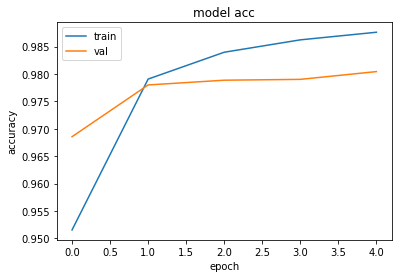

In [ ]:
print(model_bilstm.history.history.keys())
plt.plot(model_bilstm.history.history['accuracy'])
plt.plot(model_bilstm.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
pred = model_bilstm.predict(X_test).argmax(2)

In [ ]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

           O       0.93      0.91      0.92     40480
       B-PER       0.67      0.90      0.77      3542
       I-PER       0.71      0.96      0.82      7544
       B-ORG       0.71      0.61      0.65      4074
       I-ORG       0.83      0.72      0.77      8008
       B-LOC       0.83      0.72      0.77      4560
       I-LOC       0.93      0.61      0.74      3060
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.82      0.81      0.80    540000
weighted avg       0.98      0.98      0.98    540000



In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = embeddings(inputs)

bigru_1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
bigru_2 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(bigru_1)
bigru_3 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(bigru_2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(bigru_3)

model_bigru = tf.keras.Model(inputs=inputs, outputs=outputs)
model_bigru.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy', 
                     metrics=['accuracy'])

In [ ]:
model_bigru.fit(X, y, 
              validation_data=(X_test, y_test),
              batch_size=128,
              epochs=5)

Epoch 1/5
157/157 [==============================] - 245s 1s/step - loss: 0.1720 - accuracy: 0.9600 - val_loss: 0.0748 - val_accuracy: 0.9758
Epoch 2/5
157/157 [==============================] - 230s 1s/step - loss: 0.0594 - accuracy: 0.9811 - val_loss: 0.0794 - val_accuracy: 0.9735
Epoch 3/5
157/157 [==============================] - 228s 1s/step - loss: 0.0482 - accuracy: 0.9847 - val_loss: 0.0617 - val_accuracy: 0.9794
Epoch 4/5
157/157 [==============================] - 228s 1s/step - loss: 0.0417 - accuracy: 0.9867 - val_loss: 0.0544 - val_accuracy: 0.9820
Epoch 5/5
157/157 [==============================] - 229s 1s/step - loss: 0.0365 - accuracy: 0.9885 - val_loss: 0.0591 - val_accuracy: 0.9810


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


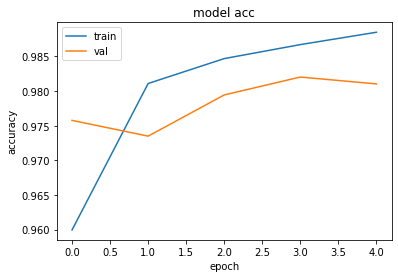

In [ ]:
print(model_bigru.history.history.keys())
plt.plot(model_bigru.history.history['accuracy'])
plt.plot(model_bigru.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
pred = model_bigru.predict(X_test).argmax(2)

In [ ]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

           O       0.94      0.90      0.92     40480
       B-PER       0.73      0.89      0.80      3542
       I-PER       0.73      0.96      0.83      7544
       B-ORG       0.77      0.54      0.64      4074
       I-ORG       0.79      0.75      0.77      8008
       B-LOC       0.79      0.74      0.77      4560
       I-LOC       0.76      0.79      0.78      3060
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.81      0.82      0.81    540000
weighted avg       0.98      0.98      0.98    540000



Качество моделей по метрикам практически не отличается, значение f1-score и для модели с 3 BILSTM-слоями, и для модели с 3 BIGRU-слоями равно 0.98. Исходя из значений f-меры, в BILSTM модели хуже всего определяется I-LOC (f1 = 0.74), модель с BIGRU-слоями хуже всего предсказывает класс B-ORG (f1 = 0.64).

Сравним модели на конкретных примерах:

In [ ]:
import re

def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(tf.keras.preprocessing.sequence.pad_sequences([ids], 
                                                                       maxlen=max_len, 
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))
    
    return list(zip(tokens, labels))

In [ ]:
def check_accuracy (text):
  print('Модель с BILSTM-слоями:')
  print(label_seq(text, word2id, id2labels, MAX_LEN, model_bilstm))
  print('Модель с BIGRU-слоями:')
  print(label_seq(text, word2id, id2labels, MAX_LEN, model_bigru))

In [ ]:
check_accuracy('Как найти площадь Ленина? Надо длину Ленина умножить на ширину Ленина.')

Модель с BILSTM-слоями:
[('Как', 'O'), ('найти', 'O'), ('площадь', 'O'), ('Ленина', 'I-ORG'), ('?', 'O'), ('Надо', 'O'), ('длину', 'O'), ('Ленина', 'O'), ('умножить', 'O'), ('на', 'O'), ('ширину', 'B-PER'), ('Ленина', 'I-PER'), ('.', 'O')]
Модель с BIGRU-слоями:
[('Как', 'O'), ('найти', 'O'), ('площадь', 'I-ORG'), ('Ленина', 'I-ORG'), ('?', 'O'), ('Надо', 'O'), ('длину', 'O'), ('Ленина', 'I-ORG'), ('умножить', 'I-ORG'), ('на', 'O'), ('ширину', 'B-ORG'), ('Ленина', 'I-ORG'), ('.', 'O')]


Модель с BILSTM-слоями не определила "площадь" как B-LOC, неправильно проставила тэг у Ленина в первом случае, не проставила тэг у Ленина во втором, в третьем случае определина "ширину Ленина" определила как составное имя. Модель с BIGRU-слоями неправильно определила "площадь" и "Ленина" (во всех трех случаях) как I-ORG, ошибочно приписала тэги "умножить" и "ширину".

С этим заданием обе модели справились плохо.

In [ ]:
check_accuracy('Посол Израиля на Украине Йоэль Лион признался, что пришел в шок, \
узнав о решении властей Львовской области объявить 2019 год годом лидера \
запрещенной в России Организации украинских националистов (ОУН) Степана Бандеры.')

Модель с BILSTM-слоями:
[('Посол', 'B-ORG'), ('Израиля', 'I-ORG'), ('на', 'O'), ('Украине', 'B-LOC'), ('Йоэль', 'O'), ('Лион', 'B-LOC'), ('признался', 'I-PER'), (',', 'O'), ('что', 'O'), ('пришел', 'O'), ('в', 'O'), ('шок', 'O'), (',', 'O'), ('узнав', 'O'), ('о', 'O'), ('решении', 'O'), ('властей', 'O'), ('Львовской', 'B-LOC'), ('области', 'O'), ('объявить', 'O'), ('2019', 'I-PER'), ('год', 'O'), ('годом', 'O'), ('лидера', 'O'), ('запрещенной', 'O'), ('в', 'O'), ('России', 'O'), ('Организации', 'O'), ('украинских', 'B-PER'), ('националистов', 'I-PER'), ('(', 'O'), ('ОУН', 'B-PER'), (')', 'O'), ('Степана', 'B-PER'), ('Бандеры', 'I-PER'), ('.', 'O')]
Модель с BIGRU-слоями:
[('Посол', 'B-ORG'), ('Израиля', 'I-ORG'), ('на', 'O'), ('Украине', 'I-ORG'), ('Йоэль', 'O'), ('Лион', 'B-LOC'), ('признался', 'I-ORG'), (',', 'O'), ('что', 'O'), ('пришел', 'O'), ('в', 'O'), ('шок', 'O'), (',', 'O'), ('узнав', 'O'), ('о', 'O'), ('решении', 'O'), ('властей', 'O'), ('Львовской', 'B-LOC'), ('области', 'I

Обе модели определили "посол Израиля" как организацию, проставили ошибочные тэги и частично не проставили их для "Йоэль Лион", ошибочно поставили тэг "признался", "2019", сделали ошибки в определении организации ОУН.

В целом у модели с BIGRU-слоями больше ошибок, в отличие от BILSTM-модели, она неверно проставила тэг у "Украине", не проставила тэги у "Степана Бандеры", проставила тэги у "год", "объявить". При этом BILSTM-модель не проставила тэг у "области" и "России".

In [ ]:
check_accuracy('Виктор, Семен, Петр, Арагорн учатся в вышке, плешке и сеченовке.')

Модель с BILSTM-слоями:
[('Виктор', 'B-PER'), (',', 'I-PER'), ('Семен', 'I-PER'), (',', 'I-PER'), ('Петр', 'I-PER'), (',', 'O'), ('Арагорн', 'I-PER'), ('учатся', 'I-PER'), ('в', 'O'), ('вышке', 'B-PER'), (',', 'I-PER'), ('плешке', 'I-PER'), ('и', 'O'), ('сеченовке', 'B-PER'), ('.', 'O')]
Модель с BIGRU-слоями:
[('Виктор', 'B-PER'), (',', 'I-PER'), ('Семен', 'I-PER'), (',', 'I-PER'), ('Петр', 'I-PER'), (',', 'I-PER'), ('Арагорн', 'O'), ('учатся', 'I-PER'), ('в', 'O'), ('вышке', 'B-PER'), (',', 'O'), ('плешке', 'I-PER'), ('и', 'O'), ('сеченовке', 'O'), ('.', 'O')]


BILSTM-модель посчитала, что "Виктор, Семен, Петр" -- это одна сущность, у "Арагорн" неправильно проставлен тэг I-PER, "учатся" ошибочно приписан тэг, "вышке, плешке" неверно объединено в одну сущность "персона",

BIGRU-модель добавила в сущность к трем именам запятую, не определив Арагорна, "учатся" ошибочно приписан тэг, "вышке", "плешке" неправильно проставлен тэг, "сеченовке" не определено.

В целом у обеих моделей много ошибок.
